In [1]:
from data import create_dataset, create_dataloader
from models import CoordAtt
from utils import torch_seed
from focal_loss import FocalLoss
import yaml

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from typing import List

In [2]:
cfg = yaml.load(open('./configs/capsule.yaml','r'), Loader=yaml.FullLoader)

In [3]:
cfg

{'EXP_NAME': 'MemSeg',
 'SEED': 42,
 'DATASET': {'datadir': '/home/daming/workspace/datasets/MVTec',
  'texture_source_dir': '/home/daming/workspace/datasets/dtd/images',
  'target': 'capsule',
  'resize': [256, 256],
  'structure_grid_size': 8,
  'transparency_range': [0.15, 1.0],
  'perlin_scale': 6,
  'min_perlin_scale': 0,
  'perlin_noise_threshold': 0.5},
 'DATALOADER': {'batch_size': 8, 'num_workers': 0},
 'MEMORYBANK': {'nb_memory_sample': 30},
 'MODEL': {'feature_extractor_name': 'resnet18'},
 'TRAIN': {'batch_size': 8,
  'num_training_steps': 5000,
  'l1_weight': 0.6,
  'focal_weight': 0.4,
  'focal_alpha': None,
  'focal_gamma': 4,
  'use_wandb': True},
 'OPTIMIZER': {'lr': 0.003, 'weight_decay': 0.0005},
 'SCHEDULER': {'min_lr': 0.0001, 'warmup_ratio': 0.1, 'use_scheduler': True},
 'LOG': {'log_interval': 1, 'eval_interval': 100},
 'RESULT': {'savedir': './saved_model'}}

# Load Dataset

In [4]:
trainset = create_dataset(
    datadir                = cfg['DATASET']['datadir'],
    target                 = cfg['DATASET']['target'], 
    train                  = True,
    resize                 = cfg['DATASET']['resize'],
    texture_source_dir     = cfg['DATASET']['texture_source_dir'],
    structure_grid_size    = cfg['DATASET']['structure_grid_size'],
    transparency_range     = cfg['DATASET']['transparency_range'],
    perlin_scale           = cfg['DATASET']['perlin_scale'], 
    min_perlin_scale       = cfg['DATASET']['min_perlin_scale'], 
    perlin_noise_threshold = cfg['DATASET']['perlin_noise_threshold']
)

In [5]:
dataloader = create_dataloader(
    dataset     = trainset,
    train       = True,
    batch_size  = cfg['DATALOADER']['batch_size'],
    num_workers = cfg['DATALOADER']['num_workers']
)

Text(0.5, 1.0, 'mask')

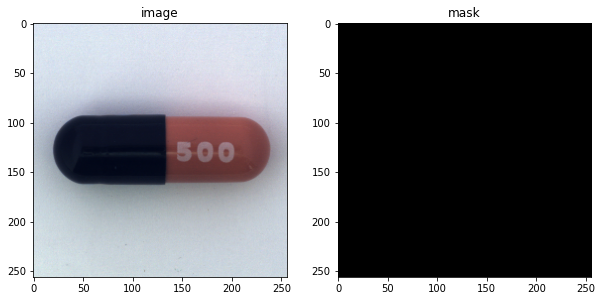

In [6]:
def minmax_scaling(img):
    return (((img - img.min()) / (img.max() - img.min())) * 255).to(torch.uint8)

img, mask, target = trainset[0]

fig, ax = plt.subplots(1,2,figsize=(10,15))
ax[0].imshow(minmax_scaling(img.permute(1,2,0)))
ax[0].set_title('image')
ax[1].imshow(minmax_scaling(mask), cmap='gray')
ax[1].set_title('mask')

# Model Overview
![image](https://user-images.githubusercontent.com/37654013/198830480-38e8d44b-e502-4f10-a396-321b2b318dfa.png)

# 1. Feature Extraction

In [8]:
from timm import create_model

In [9]:
torch_seed(10)
inputs, masks, targets = next(iter(dataloader))

In [14]:
targets

tensor([1, 0, 1, 0, 1, 0, 1, 0])

In [16]:
feature_extractor = create_model(
    'resnet18',
    pretrained=True, 
    features_only=True
)

features = feature_extractor(inputs)
f_in = features[0]
f_out = features[-1]
f_ii = features[1:-1]

for o in features:
    print(o.size())

torch.Size([8, 64, 128, 128])
torch.Size([8, 64, 64, 64])
torch.Size([8, 128, 32, 32])
torch.Size([8, 256, 16, 16])
torch.Size([8, 512, 8, 8])


In [18]:
features[0].shape

torch.Size([8, 64, 128, 128])

In [19]:
for l in ['layer1','layer2','layer3']:
    for p in feature_extractor[l].parameters():
        p.requires_grad = False

# 2. Memory Module

$$DI = \bigcup_{i=1}^{N}||MI_i - II||_2$$
$$DI^*= \text{argmin}_{DI_i \in DI} \sum_{x \in DI_i} x$$

In [20]:
class MemoryBank:
    def __init__(self, normal_dataset, nb_memory_sample: int = 30, device='cpu'):
        self.device = device
        
        # memory bank
        self.memory_information = {}
        
        # normal dataset
        self.normal_dataset = normal_dataset
        
        # the number of samples saved in memory bank
        self.nb_memory_sample = nb_memory_sample
        
        
    def update(self, feature_extractor):
        feature_extractor.eval()
        
        # define sample index
        samples_idx = np.arange(len(self.normal_dataset))
        np.random.shuffle(samples_idx)
        
        # extract features and save features into memory bank
        with torch.no_grad():
            for i in range(self.nb_memory_sample):
                # select image
                input_normal, _, _ = self.normal_dataset[samples_idx[i]]
                input_normal = input_normal.to(self.device)
                
                # extract features
                features = feature_extractor(input_normal.unsqueeze(0))
                
                # save features into memoery bank
                for i, features_l in enumerate(features[1:-1]):
                    if f'level{i}' not in self.memory_information.keys():
                        self.memory_information[f'level{i}'] = features_l
                    else:
                        self.memory_information[f'level{i}'] = torch.cat([self.memory_information[f'level{i}'], features_l], dim=0)

                        
    def _calc_diff(self, features: List[torch.Tensor]) -> torch.Tensor:
        # batch size X the number of samples saved in memory
        diff_bank = torch.zeros(features[0].size(0), self.nb_memory_sample)

        # level
        for l, level in enumerate(self.memory_information.keys()):
            # batch
            for b_idx, features_b in enumerate(features[l]):
                # calculate l2 loss
                diff = F.mse_loss(
                    input     = torch.repeat_interleave(features_b.unsqueeze(0), repeats=self.nb_memory_sample, dim=0), 
                    target    = self.memory_information[level], 
                    reduction ='none'
                ).mean(dim=[1,2,3])

                # sum loss
                diff_bank[b_idx] += diff
                
        return diff_bank
        
    
    def select(self, features: List[torch.Tensor]) -> torch.Tensor:
        # calculate difference between features and normal features of memory bank
        diff_bank = self._calc_diff(features=features)
        
        # concatenate features with minimum difference features of memory bank
        for l, level in enumerate(self.memory_information.keys()):
            
            selected_features = torch.index_select(self.memory_information[level], dim=0, index=diff_bank.argmin(dim=1))
            diff_features = F.mse_loss(selected_features, features[l], reduction='none')
            features[l] = torch.cat([features[l], diff_features], dim=1)
            
        return features
    

In [21]:
memory_bank = MemoryBank(
    normal_dataset = trainset,
    nb_memory_sample = cfg['MEMORYBANK']['nb_memory_sample']
)
# num of memory bank

In [25]:
memory_bank.normal_dataset.__len__()

219

In [26]:
memory_bank.update(feature_extractor=feature_extractor)

In [40]:
memory_bank.memory_information['level0'].shape

torch.Size([30, 64, 64, 64])

In [35]:
for k,v in memory_bank.memory_information.items():
    print(f'MI {k}: {v.size()}')

MI level0: torch.Size([30, 64, 64, 64])
MI level1: torch.Size([30, 128, 32, 32])
MI level2: torch.Size([30, 256, 16, 16])


In [50]:
f_ii[0].shape

torch.Size([8, 128, 64, 64])

In [41]:
concat_features = memory_bank.select(features = f_ii)

In [45]:
concat_features[0].shape

torch.Size([8, 128, 64, 64])

In [46]:
for i, f in enumerate(concat_features):
    print(f'CI_{i}: {f.size()}')

CI_0: torch.Size([8, 128, 64, 64])
CI_1: torch.Size([8, 256, 32, 32])
CI_2: torch.Size([8, 512, 16, 16])


# 3. Multi-scale Feature Fusion Module

그림이 잘못 그려짐 channel이 클수록 작은 feature map size임

![image](https://user-images.githubusercontent.com/37654013/198830553-8bb7814f-5b4d-4ab1-b0bf-321f3d620f5e.png)

In [51]:
class MSFFBlock(nn.Module):
    def __init__(self, in_channel):
        super(MSFFBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, in_channel, kernel_size=3, stride=1, padding=1)
        self.attn = CoordAtt(in_channel, in_channel)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channel, in_channel // 2, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channel // 2, in_channel // 2, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        x_conv = self.conv1(x)
        x_att = self.attn(x)
        
        x = x_conv * x_att
        x = self.conv2(x)
        return x

    
class MSFF(nn.Module):
    def __init__(self):
        super(MSFF, self).__init__()
        self.blk1 = MSFFBlock(128)
        self.blk2 = MSFFBlock(256)
        self.blk3 = MSFFBlock(512)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.upconv32 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        )
        self.upconv21 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, features):
        # features = [level1, level2, level3]
        f1, f2, f3 = features 
        
        # MSFF Module
        f1_k = self.blk1(f1)
        f2_k = self.blk2(f2)
        f3_k = self.blk3(f3)

        f2_f = f2_k + self.upconv32(f3_k)
        f1_f = f1_k + self.upconv21(f2_f)

        # spatial attention
        
        # mask 
        m3 = f3[:,256:,...].mean(dim=1, keepdim=True)
        m2 = f2[:,128:,...].mean(dim=1, keepdim=True) * self.upsample(m3)
        m1 = f1[:,64:,...].mean(dim=1, keepdim=True) * self.upsample(m2)
        
        f1_out = f1_f * m1
        f2_out = f2_f * m2
        f3_out = f3_k * m3
        
        return [f1_out, f2_out, f3_out]

In [52]:
msff_module = MSFF()

In [53]:
msff_outputs = msff_module(features=concat_features)

In [54]:
for l, o in enumerate(msff_outputs):
    print(f'level{l+1}: {o.size()}')

level1: torch.Size([8, 64, 64, 64])
level2: torch.Size([8, 128, 32, 32])
level3: torch.Size([8, 256, 16, 16])


## Coordinate Attention

![image](https://user-images.githubusercontent.com/37654013/198845131-8ae9a160-55a0-4266-bcaf-58904649fbec.png)


In [55]:
# https://github.com/houqb/CoordAttention/blob/main/coordatt.py

class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6

class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class CoordAtt(nn.Module):
    def __init__(self, inp, oup, reduction=32):
        super(CoordAtt, self).__init__()
        self.pool_h = nn.AdaptiveAvgPool2d(output_size=(None, 1)) # X Avg Pool
        self.pool_w = nn.AdaptiveAvgPool2d(output_size=(1, None)) # Y Avg Pool

        mip = max(8, inp // reduction)

        self.conv1 = nn.Conv2d(inp, mip, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(mip)
        self.act = h_swish()
        
        self.conv_h = nn.Conv2d(mip, oup, kernel_size=1, stride=1, padding=0)
        self.conv_w = nn.Conv2d(mip, oup, kernel_size=1, stride=1, padding=0)
        

    def forward(self, x):
        identity = x
        
        n,c,h,w = x.size()
        x_h = self.pool_h(x)
        x_w = self.pool_w(x).permute(0, 1, 3, 2)

        y = torch.cat([x_h, x_w], dim=2)
        y = self.conv1(y)
        y = self.bn1(y)
        y = self.act(y) 
        
        x_h, x_w = torch.split(y, [h, w], dim=2)
        x_w = x_w.permute(0, 1, 3, 2)

        a_h = self.conv_h(x_h).sigmoid()
        a_w = self.conv_w(x_w).sigmoid()

        out = identity * a_w * a_h

        return out

## Spatial Attention

$$M_3 = \frac{1}{C_3} \sum_{i=1}^{C_3} DI_{3i}^{*}$$
$$M_2= \frac{1}{C_2} \sum_{i=1}^{C_2} DI_{2i}^{*} ⊙ M_3^U$$
$$M_1= \frac{1}{C_1} \sum_{i=1}^{C_1} DI_{1i}^{*} ⊙ M_2^U$$

In [56]:
upsample = torch.nn.Upsample(scale_factor=2)

m3 = concat_features[2][:,256:,...].mean(dim=1, keepdim=True).detach().cpu()
m2 = concat_features[1][:,128:,...].mean(dim=1, keepdim=True).detach().cpu() * upsample(m3)
m1 = concat_features[0][:,64:,...].mean(dim=1, keepdim=True).detach().cpu() * upsample(m2)

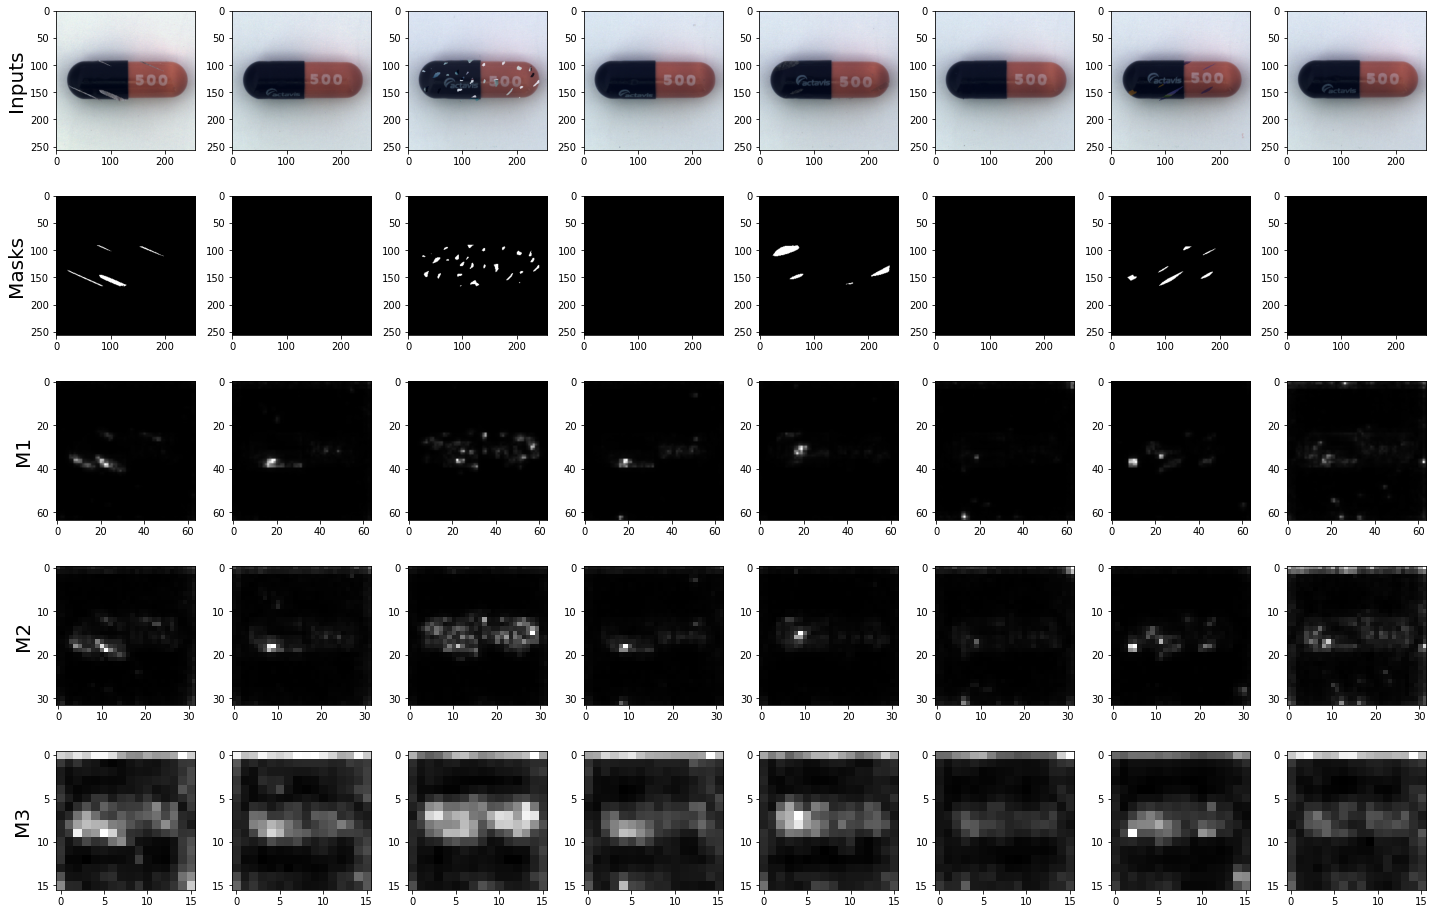

In [57]:
bs = inputs.size(0)
fig, ax = plt.subplots(5, bs, figsize=(20,13))

for i in range(bs):
    ax[0, i%bs].imshow(minmax_scaling(inputs[i].permute(1,2,0)))
    ax[1, i%bs].imshow(masks[i], cmap='gray')
    ax[2, i%bs].imshow(m1[i][0], cmap='gray')
    ax[3, i%bs].imshow(m2[i][0], cmap='gray')
    ax[4, i%bs].imshow(m3[i][0], cmap='gray')
    
    if i == 0:
        titles = ['Inputs','Masks','M1','M2','M3']
        for i in range(5):
            ax[i, 0].set_ylabel(titles[i], size=20)
plt.tight_layout()

# 4. Decoder

![image](https://user-images.githubusercontent.com/37654013/198830480-38e8d44b-e502-4f10-a396-321b2b318dfa.png)

In [58]:
class UpConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(UpConvBlock, self).__init__()
        self.blk = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )

    def forward(self, x):
        return self.blk(x)


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.conv = nn.Conv2d(64, 48, kernel_size=3, stride=1, padding=1)

        self.upconv3 = UpConvBlock(512, 256)
        self.upconv2 = UpConvBlock(512, 128)
        self.upconv1 = UpConvBlock(256, 64)
        self.upconv0 = UpConvBlock(128, 48)
        self.upconv2mask = UpConvBlock(96, 48)

        self.final_conv = nn.Conv2d(48, 2, kernel_size=3, stride=1, padding=1)

    def forward(self, encoder_output, concat_features):
        # concat_features = [level0, level1, level2, level3]
        f0, f1, f2, f3 = concat_features
        
        # 512 x 8 x 8 -> 512 x 16 x 16
        x_up3 = self.upconv3(encoder_output)
        x_up3 = torch.cat([x_up3, f3], dim=1)  

        # 512 x 16 x 16 -> 256 x 32 x 32
        x_up2 = self.upconv2(x_up3)
        x_up2 = torch.cat([x_up2, f2], dim=1)  

        # 256 x 32 x 32 -> 128 x 64 x 64
        x_up1 = self.upconv1(x_up2)
        x_up1 = torch.cat([x_up1, f1], dim=1)  

        # 128 x 64 x 64 -> 96 x 128 x 128
        x_up0 = self.upconv0(x_up1)
        f0 = self.conv(f0)
        x_up2mask = torch.cat([x_up0, f0], dim=1)  

        # 96 x 128 x 128 -> 48 x 256 x 256
        x_mask = self.upconv2mask(x_up2mask)  
        
        # 48 x 256 x 256 -> 1 x 256 x 256
        x_mask = self.final_conv(x_mask)  
        
        return x_mask

In [59]:
decoder = Decoder()

predicted_masks = decoder(
    encoder_output = f_out,
    concat_features = [f_in] + msff_outputs
)

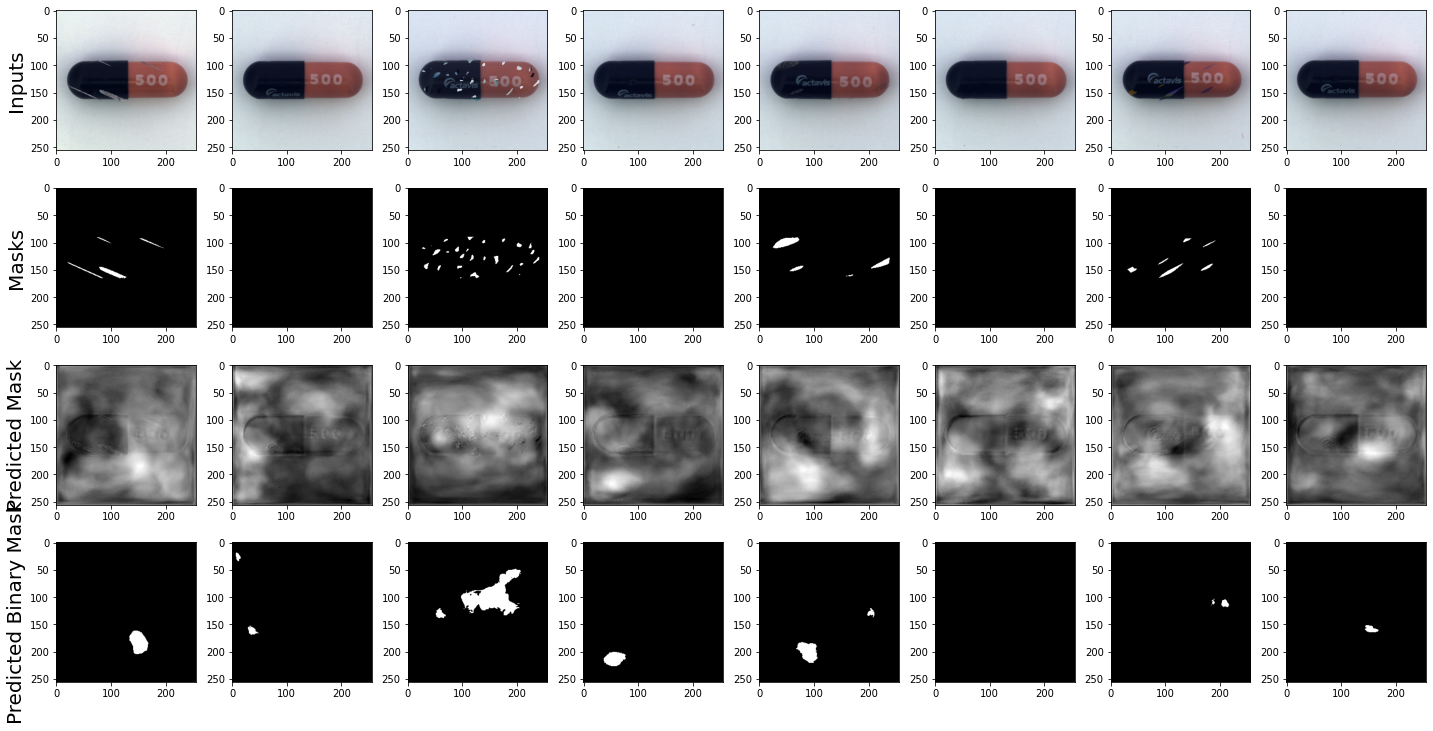

In [60]:
bs = inputs.size(0)
fig, ax = plt.subplots(4, bs, figsize=(20,10))

threshold = 0.7

for i in range(bs):
    ax[0, i%bs].imshow(minmax_scaling(inputs[i].permute(1,2,0)))
    ax[1, i%bs].imshow(masks[i], cmap='gray')
    ax[2, i%bs].imshow(predicted_masks[i][0].detach(), cmap='gray')
    ax[3, i%bs].imshow((predicted_masks[i][0].detach() > threshold).to(torch.uint8), cmap='gray')
    
    if i == 0:
        titles = ['Inputs','Masks','Predicted Mask', 'Predicted Binary Mask']
        for i in range(4):
            ax[i, 0].set_ylabel(titles[i], size=20)
plt.tight_layout()

## MemSeg

In [61]:
class MemSeg(nn.Module):
    def __init__(self, memory_bank, feature_extractor):
        super(MemSeg, self).__init__()

        self.memory_bank = memory_bank
        self.feature_extractor = feature_extractor
        self.msff = MSFF()
        self.decoder = Decoder()

    def forward(self, inputs):
        # extract features
        features = self.feature_extractor(inputs)
        f_in = features[0]
        f_out = features[-1]
        f_ii = features[1:-1]

        # extract concatenated information(CI)
        concat_features = self.memory_bank.select(features = f_ii)

        # Multi-scale Feature Fusion(MSFF) Module
        msff_outputs = self.msff(features=concat_features)

        # decoder
        predicted_mask = self.decoder(
            encoder_output = f_out,
            concat_features = [f_in] + msff_outputs
        )

        return predicted_mask

In [62]:
model = MemSeg(
    memory_bank       = memory_bank,
    feature_extractor = feature_extractor
)

In [63]:
outputs = model(inputs)

In [64]:
outputs.size()

torch.Size([8, 2, 256, 256])

# 5. Loss Functions

$$L_{l1} = ||S - \hat{S}||_1$$
$$L_f = -\alpha_t(1-p_t)^\gamma \log(p_t)$$
$$L_all = \lambda_{l1}L_{l1} + \lambda_{f}L_{f}$$

In [65]:
l1_criterion = nn.L1Loss()
f_criterion = FocalLoss(gamma=cfg['TRAIN']['focal_gamma'], alpha=cfg['TRAIN']['focal_alpha'])

l1_loss = l1_criterion(predicted_masks[:,1,:], masks)
focal_loss = f_criterion(predicted_masks, masks)

print('L1 loss: ',l1_loss.item())
print('focal loss: ',focal_loss.item())

L1 loss:  0.2578034996986389
focal loss:  0.049442242830991745


In [66]:
loss = cfg['TRAIN']['l1_weight'] * l1_loss + cfg['TRAIN']['focal_weight'] * focal_loss

In [67]:
print('total loss: ',loss.item())

total loss:  0.17445899546146393


# 6. Metrics

In [70]:
from anomalib.utils.metrics import AUPRO, AUROC

ModuleNotFoundError: No module named 'anomalib'

In [61]:
auroc_image_metric = AUROC(num_classes=1, pos_label=1)
auroc_pixel_metric = AUROC(num_classes=1, pos_label=1)
aupro_pixel_metric = AUPRO()

/home/tootouch/.local/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [62]:
predicted_anomaly_score = torch.topk(torch.flatten(predicted_masks[:,1,:], start_dim=1), 100)[0].mean(dim=1)

auroc_image_metric.update(
    preds = predicted_anomaly_score, 
    target = targets
)

print('AUROC image-level: ',auroc_image_metric.compute().item())

AUROC image-level:  0.5333333015441895


In [63]:
auroc_pixel_metric.update(
    preds  = predicted_masks[:,1,:],
    target = masks
)

print('AUROC pixel-level: ',auroc_pixel_metric.compute().item())

AUROC pixel-level:  0.43786996603012085


In [83]:
aupro_pixel_metric.update(
    preds   = predicted_masks[:,1,:],
    target  = masks
)

print('AUPRO pixel-level: ',aupro_pixel_metric.compute().item())

AUPRO pixel-level:  0.27686619758605957


## N square
